In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, fbeta_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

sns.set_theme(style='whitegrid', context='paper')

In [2]:
training_df = pd.read_csv('data/network-traffic/kddcup.data.corrected.csv')
testing_df = pd.read_csv('data/network-traffic/corrected.csv')
complete_df = pd.read_csv('data/network-traffic/kddcup.data.complete.csv')

training_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,attack_class
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal,normal
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal,normal
2,0,tcp,http,SF,236,1228,0,0,0,0,...,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal,normal
3,0,tcp,http,SF,233,2032,0,0,0,0,...,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal,normal
4,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal,normal


In [3]:
# Label encode the target and categorical variables
categorical_columns = ['protocol_type', 'service', 'flag', 'target']

label_encoder = LabelEncoder()

for col in categorical_columns:
    training_df[col] = label_encoder.fit_transform(training_df[col])
    testing_df[col] = label_encoder.fit_transform(testing_df[col])
    complete_df[col] = label_encoder.fit_transform(complete_df[col])


# Attack Detection (with F-beta score)

In [4]:
# Split data into features (X) and target (y)
X_train = training_df.drop(['target', 'attack_class'], axis=1)
y_train = training_df['target']

X_test = testing_df.drop(['target', 'attack_class'], axis=1)
y_test = testing_df['target']

X_complete = complete_df.drop(['target', 'attack_class'], axis=1)
y_complete = complete_df['target']

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.3, random_state=404, stratify=y_train)

In [5]:
# Train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=404, n_jobs=-1)
rf.fit(X_train_split, y_train_split)

# Extract feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature importances in descending order
print("Feature ranking:")
for rank, idx in enumerate(indices):
    print(f"{rank + 1}. Feature: {X_train_split.columns[idx]}, Importance: {importances[idx]}")

print(f"model score on training data: {rf.score(X_train_split, y_train_split)}")
print(f"model score on testing data: {rf.score(X_test_split, y_test_split)}")

Feature ranking:
1. Feature: same_srv_rate, Importance: 0.20617792470275528
2. Feature: count, Importance: 0.13557898553470926
3. Feature: diff_srv_rate, Importance: 0.12331557065484737
4. Feature: dst_host_srv_serror_rate, Importance: 0.07154581827569999
5. Feature: src_bytes, Importance: 0.06489432921261838
6. Feature: flag, Importance: 0.06364017314127991
7. Feature: dst_bytes, Importance: 0.051578837482626115
8. Feature: serror_rate, Importance: 0.04725801893751932
9. Feature: dst_host_same_srv_rate, Importance: 0.03993585828809181
10. Feature: srv_serror_rate, Importance: 0.03815783221510433
11. Feature: dst_host_serror_rate, Importance: 0.03419672144838255
12. Feature: service, Importance: 0.018471324945333926
13. Feature: dst_host_same_src_port_rate, Importance: 0.013311585099445437
14. Feature: dst_host_rerror_rate, Importance: 0.011836513407905163
15. Feature: dst_host_diff_srv_rate, Importance: 0.01114816143171032
16. Feature: dst_host_srv_count, Importance: 0.010712922234256

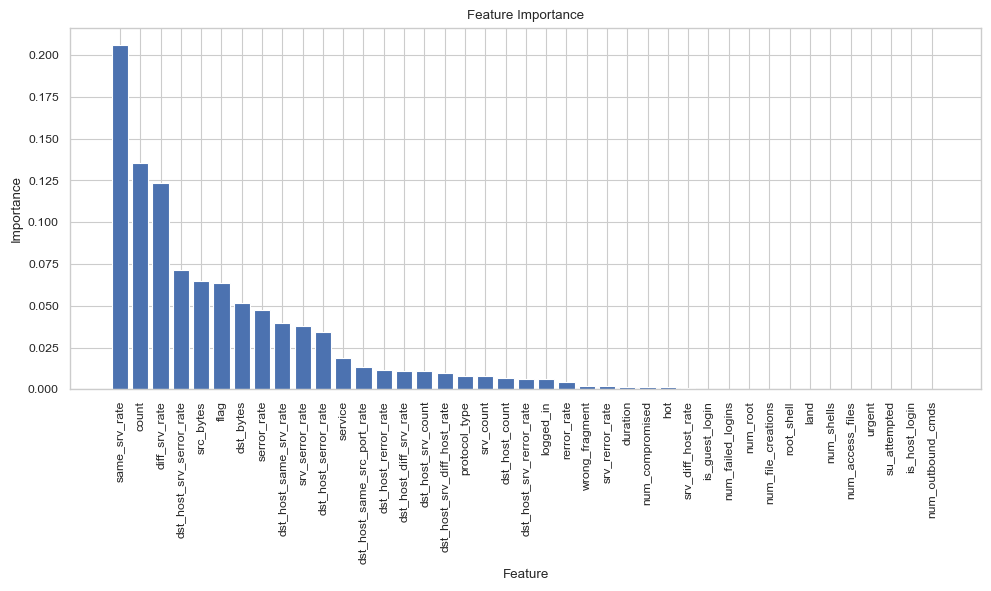

In [6]:
plt.figure(figsize=(10, 6))
plt.bar(range(X_train_split.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train_split.shape[1]), X_train_split.columns[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [7]:
# Evaluate model performance with and without specific features
def evaluate_model(features):
    X_train_subset = X_train_split[features]
    X_test_subset = X_test_split[features]
    rf.fit(X_train_subset, y_train_split)
    y_pred = rf.predict(X_test_subset)
    acc = accuracy_score(y_test_split, y_pred)
    fbeta = fbeta_score(y_test_split, y_pred, beta=10, average='macro')
    return acc, fbeta

# All features
all_features = X_train_split.columns.tolist()
all_acc, all_fbeta = evaluate_model(all_features)
print(f"All features - Accuracy: {all_acc}, F-beta Score (beta=10): {all_fbeta}")

# Identify least important features (adjust the number as needed)
least_important_features = [X_train_split.columns[indices[-i-1]] for i in range(20)] # Adjust the number as needed
print("Least important features:", least_important_features)

# Without least important features
important_features = [f for f in X_train_split.columns if f not in least_important_features]
important_acc, important_fbeta = evaluate_model(important_features)
print(f"Without least important features - Accuracy: {important_acc}, F-beta Score (beta=10): {important_fbeta}")

All features - Accuracy: 0.999755037240541, F-beta Score (beta=10): 0.6138177369985122
Least important features: ['num_outbound_cmds', 'is_host_login', 'su_attempted', 'urgent', 'num_access_files', 'num_shells', 'land', 'root_shell', 'num_file_creations', 'num_root', 'num_failed_logins', 'is_guest_login', 'srv_diff_host_rate', 'hot', 'num_compromised', 'duration', 'srv_rerror_rate', 'wrong_fragment', 'rerror_rate', 'logged_in']
Without least important features - Accuracy: 0.9997395332684234, F-beta Score (beta=10): 0.6058304993292546


# Attack Class Prediction (without Fbeta-score)

In [8]:
# Split data into features (X) and target (y)
X_train = training_df.drop(['target', 'attack_class'], axis=1)
y_train = training_df['attack_class']

X_test = testing_df.drop(['target', 'attack_class'], axis=1)
y_test = testing_df['attack_class']

X_complete = complete_df.drop(['target', 'attack_class'], axis=1)
y_complete = complete_df['attack_class']

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.3, random_state=404, stratify=y_train)

In [9]:
# Train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=404, n_jobs=-1)
rf.fit(X_train_split, y_train_split)

# Extract feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature importances in descending order
print("Feature ranking:")
for rank, idx in enumerate(indices):
    print(f"{rank + 1}. Feature: {X_train_split.columns[idx]}, Importance: {importances[idx]}")

print(f"model score on training data: {rf.score(X_train_split, y_train_split)}")
print(f"model score on testing data: {rf.score(X_test_split, y_test_split)}")

Feature ranking:
1. Feature: same_srv_rate, Importance: 0.20586995178175424
2. Feature: count, Importance: 0.14053134683397883
3. Feature: diff_srv_rate, Importance: 0.12254376658502635
4. Feature: src_bytes, Importance: 0.07086686546970632
5. Feature: dst_host_srv_serror_rate, Importance: 0.06985423788792586
6. Feature: dst_bytes, Importance: 0.05909976375785412
7. Feature: flag, Importance: 0.053876997738014826
8. Feature: serror_rate, Importance: 0.04706360020736465
9. Feature: dst_host_same_srv_rate, Importance: 0.04062868200856646
10. Feature: srv_serror_rate, Importance: 0.036956772329037435
11. Feature: dst_host_serror_rate, Importance: 0.02740415446357147
12. Feature: service, Importance: 0.021452893838748315
13. Feature: dst_host_diff_srv_rate, Importance: 0.014835471033657432
14. Feature: dst_host_same_src_port_rate, Importance: 0.013169588527779752
15. Feature: dst_host_srv_count, Importance: 0.012212413472114561
16. Feature: protocol_type, Importance: 0.010622359546261964
1

In [10]:
# Evaluate model performance with and without specific features
def evaluate_model(features):
    X_train_subset = X_train_split[features]
    X_test_subset = X_test_split[features]
    rf.fit(X_train_subset, y_train_split)
    y_pred = rf.predict(X_test_subset)
    acc = accuracy_score(y_test_split, y_pred)
    return acc

# All features
all_features = X_train_split.columns.tolist()
all_acc = evaluate_model(all_features)
print(f"All features - Accuracy: {all_acc}")

# Identify least important features (adjust the number as needed)
least_important_features = [X_train_split.columns[indices[-i-1]] for i in range(20)] # Adjust the number as needed
print("Least important features:", least_important_features)

# Without least important features
important_features = [f for f in X_train_split.columns if f not in least_important_features]
important_acc = evaluate_model(important_features)
print(f"Without least important features - Accuracy: {important_acc}")

All features - Accuracy: 0.9998201539234352
Least important features: ['is_host_login', 'num_outbound_cmds', 'su_attempted', 'land', 'urgent', 'num_shells', 'num_access_files', 'num_file_creations', 'root_shell', 'num_root', 'num_failed_logins', 'is_guest_login', 'srv_diff_host_rate', 'hot', 'num_compromised', 'duration', 'wrong_fragment', 'rerror_rate', 'srv_rerror_rate', 'dst_host_srv_rerror_rate']
Without least important features - Accuracy: 0.999801549156894
